# K-Means Clustering을 활용한 색 특징값 추출

## 0. 라이브러리

In [1]:
import os
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm
from colorsys import rgb_to_hsv
from keras.preprocessing.image import load_img

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from PIL import Image

from numpy import dot
from numpy.linalg import norm

## 1. 파일명 불러오기

In [2]:
def get_file_names(path, ends, sample_ratio = 1):
    file_names = []

    with os.scandir(path) as files:
        for file in files:
            # .jpg .png 등 확장자명이 'g'로 끝나는 파일들 모두 읽기
            if file.name.endswith(ends):
                file_names.append(path + file.name)

    if sample_ratio < 1:
        file_names = random.sample(file_names, int(len(file_names) * sample_ratio))
        
    return file_names

## 2. 데이터 추출하기

### 2-1. HSV flatten data

In [3]:
def extract_data_hsv_flatten(file_name, img_size = (360, 360), img_grid = 5, clr_grid = (12, 8, 8)):
    img = cv2.imread(file_name)
    img = cv2.resize(img, img_size)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    grid_count = np.zeros([img_grid * 2, clr_grid[0] * clr_grid[1] * clr_grid[2]])
    clr_data = []
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            newH = (int)((img_hsv[i][j][0] / 180) * clr_grid[0]) #range of H : 0 ~ 179
            newS = (int)((img_hsv[i][j][1] / 256) * clr_grid[1]) #range of S : 0 ~ 255
            newV = (int)((img_hsv[i][j][2] / 256) * clr_grid[2]) #range of V : 0 ~ 255
            label = newH * clr_grid[1] * clr_grid[2] + newS * clr_grid[2] + newV
            grid_count[(int)((i / img_size[0]) * img_grid)][label] += 1
            grid_count[img_grid + (int)((i / img_size[0]) * img_grid)][label] += 1
    for i, grid in enumerate(grid_count):
        grid_total = grid_count[i].sum()
        clr_data.append(grid_count[i] / grid_total) 
    return np.array(clr_data)

### 2-2. RGB-HSV data

In [4]:
#tf.rgb_to_hsv version (구버전)
def extract_data_rgbhsv_before(file_name, img_size = (360, 360)):
    img = load_img(file_name, target_size = img_size)
    img = np.array(img)
    img = img.reshape(img_size[0] * img_size[1], 3)
    hsv_data = []
    for pixel in img:
        hsv_data.append(rgb_to_hsv(pixel[0] / 255, pixel[1] / 255, pixel[2] / 255))
    return np.concatenate((img / 255, hsv_data), axis = 1)

In [5]:
def extract_data_rgbhsv(file_name, img_size = (360, 360)):
    img = cv2.imread(file_name)
    img = cv2.resize(img, img_size) 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).reshape(img_size[0] * img_size[1], 3)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).reshape(img_size[0] * img_size[1], 3)
    return np.concatenate((img_rgb, img_hsv), axis = 1)

### 2-3. HSV-YUV data

In [6]:
def extract_data_hsvyuv(file_name, img_size = (360, 360)):
    img = cv2.imread(file_name)
    img = cv2.resize(img, img_size)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).reshape(img_size[0] * img_size[1], 3)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV).reshape(img_size[0] * img_size[1], 3)
    return np.concatenate((img_hsv, img_yuv), axis = 1)

## 3. 클러스터링 데이터

### 3-1. Labels

In [7]:
def get_clu_labels(data, cluster = 25, state = 2021):
    km = KMeans(n_clusters = cluster, random_state = state)
    km.fit(data)
    return km.labels_

### 3-2. Visualization with each cluster

In [8]:
def show_img_with_clusters(file_name, labels, img_size = (360, 360), grid_size = (5, 5), clu_color = (0, 255, 0)):
    plt.figure(figsize = (25, 25))
    img = load_img(file_name, target_size = img_size)
    img = np.array(img)
    
    for idx in range(grid_size[0] * grid_size[1]):
        img_now = img.copy()
        new_labels =  np.array(list(map(lambda x: x == idx, labels))).reshape(img_size)
        for i, row in enumerate(img):
            for j, col in enumerate(row):
                if new_labels[i][j]:
                    img_now[i][j] = clu_color
        plt.subplot(grid_size[1], grid_size[0] ,idx+1);
        plt.imshow(img_now)
        plt.axis('off')

### 3-3. Visualization with grid

In [9]:
def show_img_with_grid(file_name, labels, img_size = (360, 360), grid = (8, 8), cluster = 25, ratio = 0.1, clu_color = (0, 255, 0)):
    plt.figure(figsize = (25, 25))
    img = load_img(file_name, target_size = img_size)
    img = np.array(img)
    new_labels =  labels.reshape(img_size)
    grid_count = np.zeros([grid[0] * grid[1], cluster])
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            grid_num = (int)(i / (img_size[0] / grid[0])) * grid[1] + (int)(j / (img_size[1] / grid[1]))
            grid_count[grid_num][new_labels[i][j]] += 1
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            grid_num = (int)(i / (img_size[0] / grid[0])) * grid[1] + (int)(j / (img_size[1] / grid[1]))
            if grid_count[grid_num][new_labels[i][j]] < (int)(img_size[0] * img_size[1] / grid[0] / grid[1] * ratio):
                img[i][j] = clu_color
    plt.imshow(img)
    plt.axis('off')    

## 4. 클러스터 데이터 추출

### 4.1. 클러스터 RGB평균, 중심 좌표, 평균 거리, 평균 표준편차, 비율

In [10]:
def grouping_clusters(file_name, labels, img_size = (360, 360), cluster = 25):
    img = cv2.imread(file_name)
    img = cv2.resize(img, img_size)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).reshape(img_size[0] * img_size[1], 3)
    
    rgbs = np.array([img_rgb[labels == i].mean(axis = 0) for i in range(cluster)])
    
    center_info = np.zeros([cluster, 3])
    new_labels = labels.reshape(img_size[0], img_size[1])
    for i in range(img_size[0]):
        for j in range(img_size[1]):
            tar = new_labels[i][j]
            center_info[tar] += [i, j, 1]    
    centers = np.array([[x / z,y / z] for [x,y,z] in center_info])
    ratios = np.array([[z / (360 * 360)] for [x,y,z] in center_info])
    
    dist_info = [[] for i in range(cluster)]
    for i in range(img_size[0]):
        for j in range(img_size[1]):
            tar = new_labels[i][j]
            dist_info[tar].append(norm(centers[tar] - [i, j]))
    dists = np.array([[np.mean(data), np.std(data)] for data in dist_info])

    return np.concatenate((rgbs, centers, dists, ratios), axis = 1)

### 4-2. Visualization with cluster quality

In [11]:
def show_img_with_cluster_quality(file_name, labels, clu_data, img_size = (360, 360)):
    plt.figure(figsize = (25, 25))
    img = load_img(file_name, target_size = img_size)
    img = np.array(img)
    
    new_labels =  labels.reshape(img_size)
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            img[i][j] = clu_data[new_labels[i][j]][0 : 3]
    plt.imshow(img)
    plt.axis('off')

### 4-3. Visualization with color ratio

In [12]:
def show_clu_by_ratio(clu_data):
    plt.figure(figsize = (8, 8))
    clu_data_sorted = clu_data[np.argsort(clu_data[:, 7])]
    plt.barh(range(len(clu_data)), clu_data_sorted[:, 7], color = clu_data[:, 0:3].astype(int)/256)
    plt.show()

### 4-4. Visualization with color position

In [32]:
def show_clu_by_pos(clu_data):
    plt.figure(figsize = (8, 8))
    plt.xlim([0, 360])
    plt.ylim([0, 360])
    plt.gca().invert_yaxis()
    plt.scatter(x = clu_data[:, 4], y = clu_data[:, 3], s= clu_data[:,7] * 10000, c = clu_data[:, 0:3].astype(int)/256)
    for i in range(len(clu_data)):
        plt.text(x = clu_data[i, 4] - 1.2, y = clu_data[i, 3] + 0.4, s = str(i), size = 'small')
    plt.show()

## 5. 데이터 저장

In [14]:
def save_clu_data(path, file_name, data):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print ('Error: Creating directory. ' +  path)
    try:
        save_name = path + file_name.rsplit('.')[0].rsplit('/')[-1] + ".npy"
        np.save(save_name, data)
    except:
        print ('Error: Creating Data. ' + save_name)

## 1~5. Extract Color

In [15]:
def extract_color_v1(img_dir, save_dir, img_size = (360, 360), clu = 25):
    file_names = get_file_names(img_dir, 'jpg', 1)
    for target_name in tqdm(file_names):
        save_name = save_dir + target_name.rsplit('.')[0].rsplit('/')[-1] + ".npy"
        if not os.path.isfile(save_name):
            hsvyuv_data = extract_data_hsvyuv(target_name, img_size = img_size)
            data_labels = get_clu_labels(hsvyuv_data, cluster = clu)
            clu_data = grouping_clusters(target_name, data_labels, cluster = clu)
            save_clu_data(save_dir, target_name, clu_data)

## Example

In [16]:
file_names = get_file_names('images/', 'jpg', 1)

In [17]:
target_name = file_names[118]

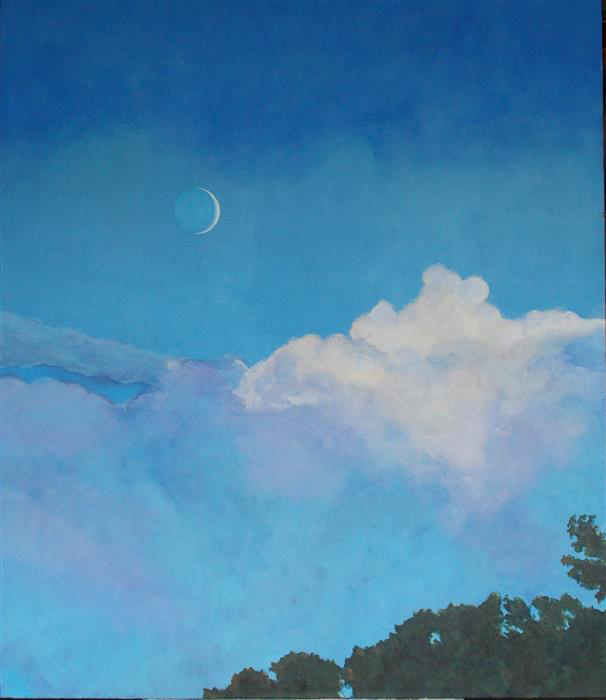

In [18]:
img = load_img(target_name)
img

In [19]:
hsvyuv_data = extract_data_hsvyuv(target_name)
hsvyuv_data

array([[106, 229, 109,  49, 158,  95],
       [106, 209, 123,  61, 159,  94],
       [106, 211, 123,  61, 159,  93],
       ...,
       [  0,   0,  34,  34, 128, 128],
       [ 90,   7,  36,  36, 128, 127],
       [  0,   0,  38,  38, 128, 128]], dtype=uint8)

In [20]:
data_labels = get_clu_labels(hsvyuv_data, cluster = 25)
data_labels

array([ 9,  9,  9, ..., 24, 24, 24])

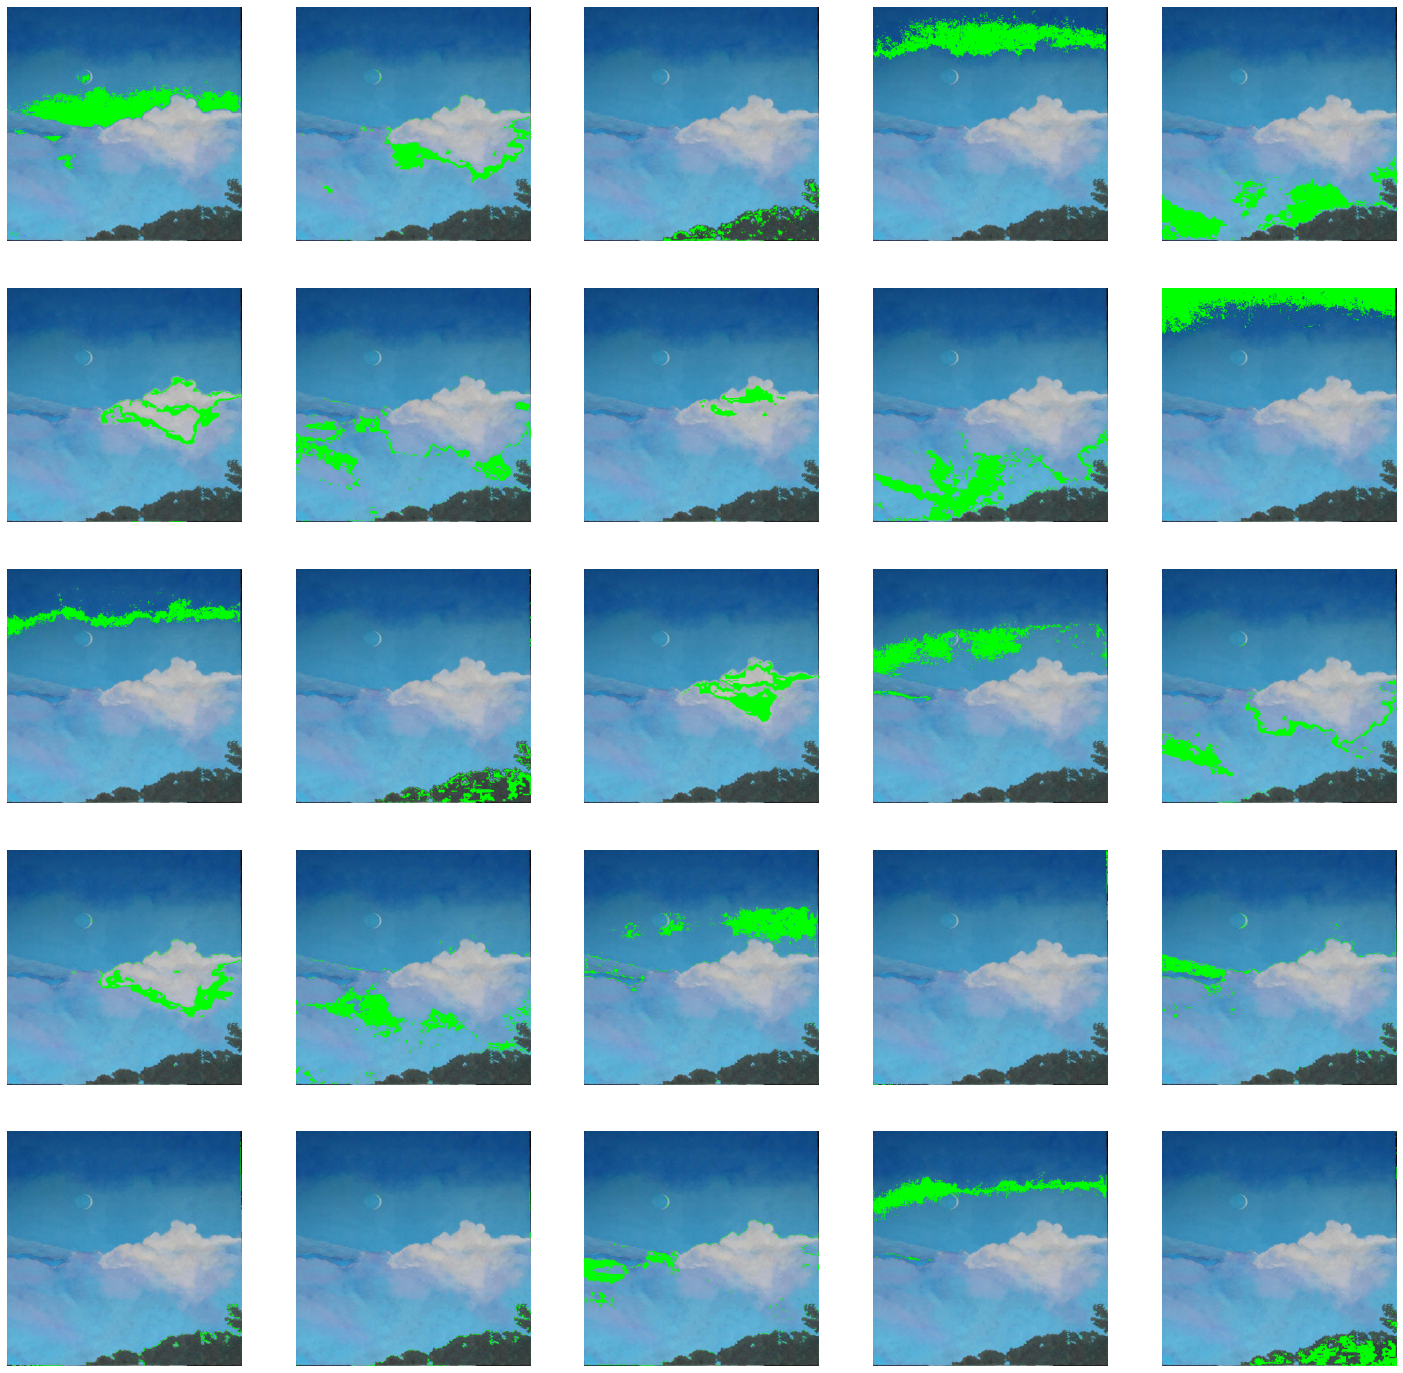

In [21]:
show_img_with_clusters(target_name, data_labels, grid_size = (5,5))

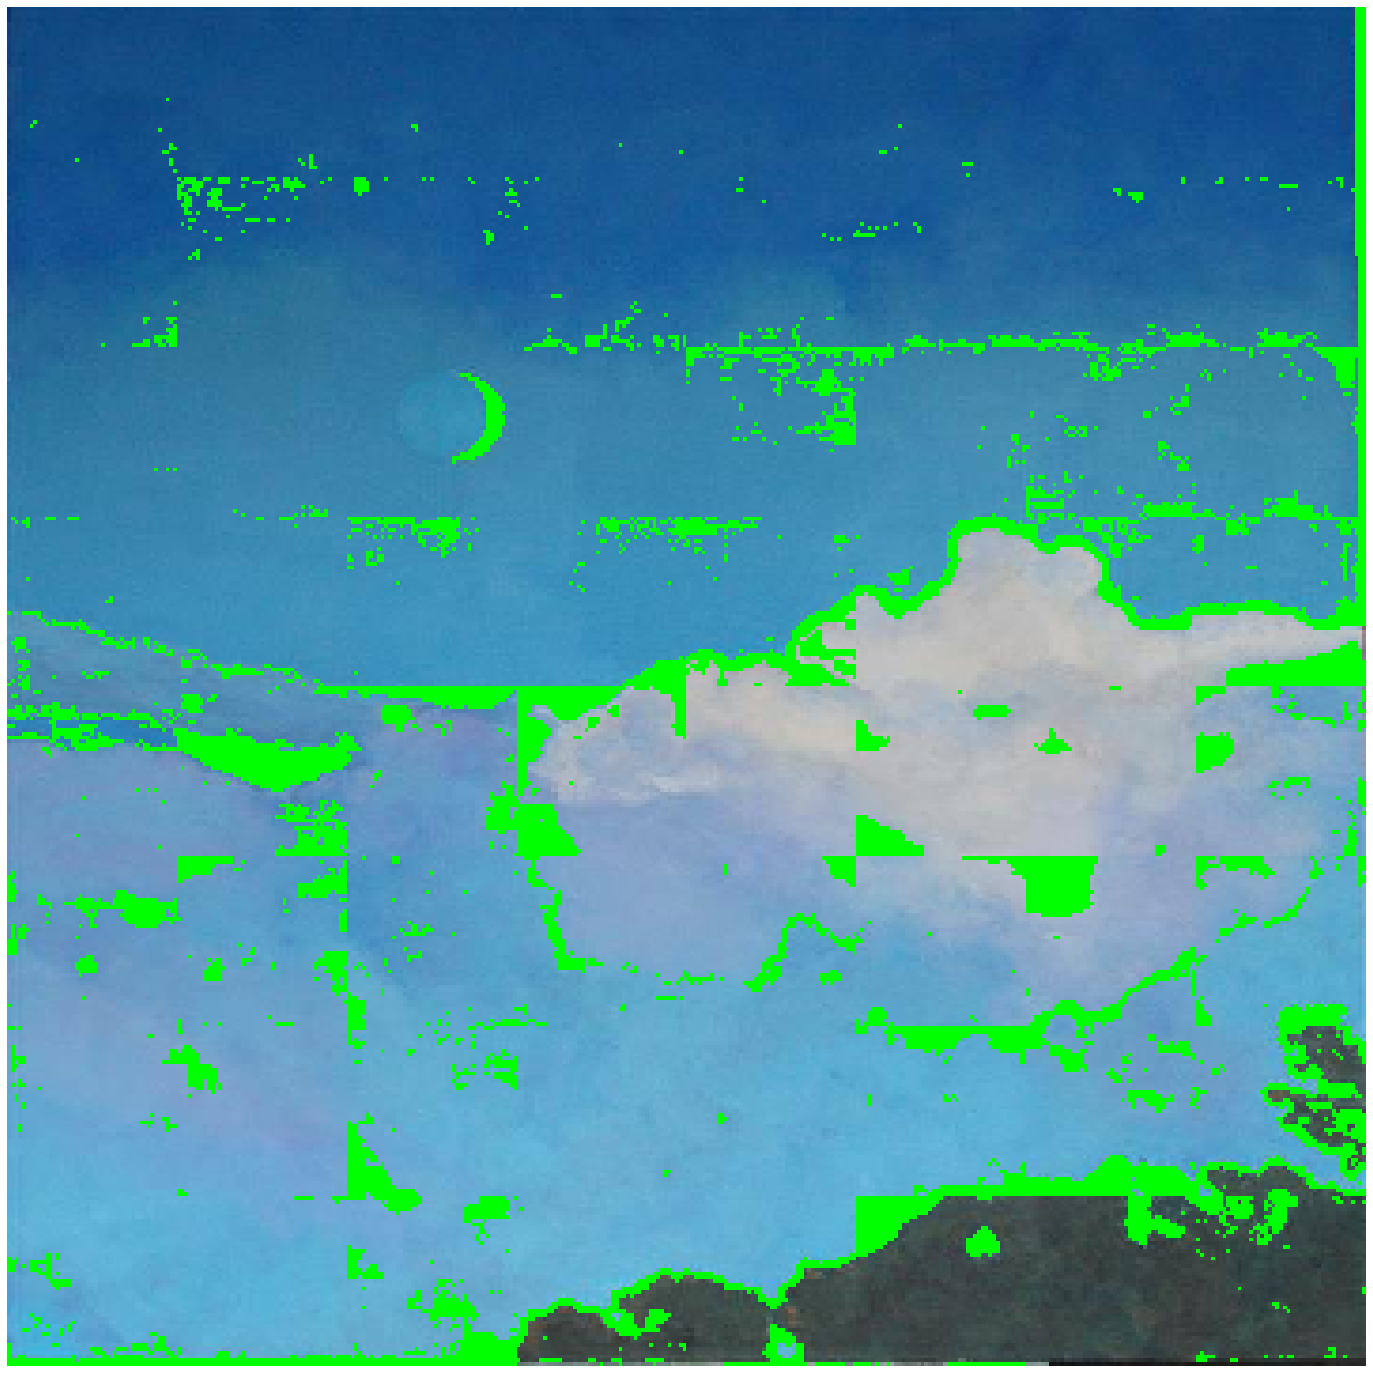

In [22]:
show_img_with_grid(target_name, data_labels, grid = [8, 8], ratio = 0.08)

In [25]:
clu_data = grouping_clusters(target_name, data_labels)

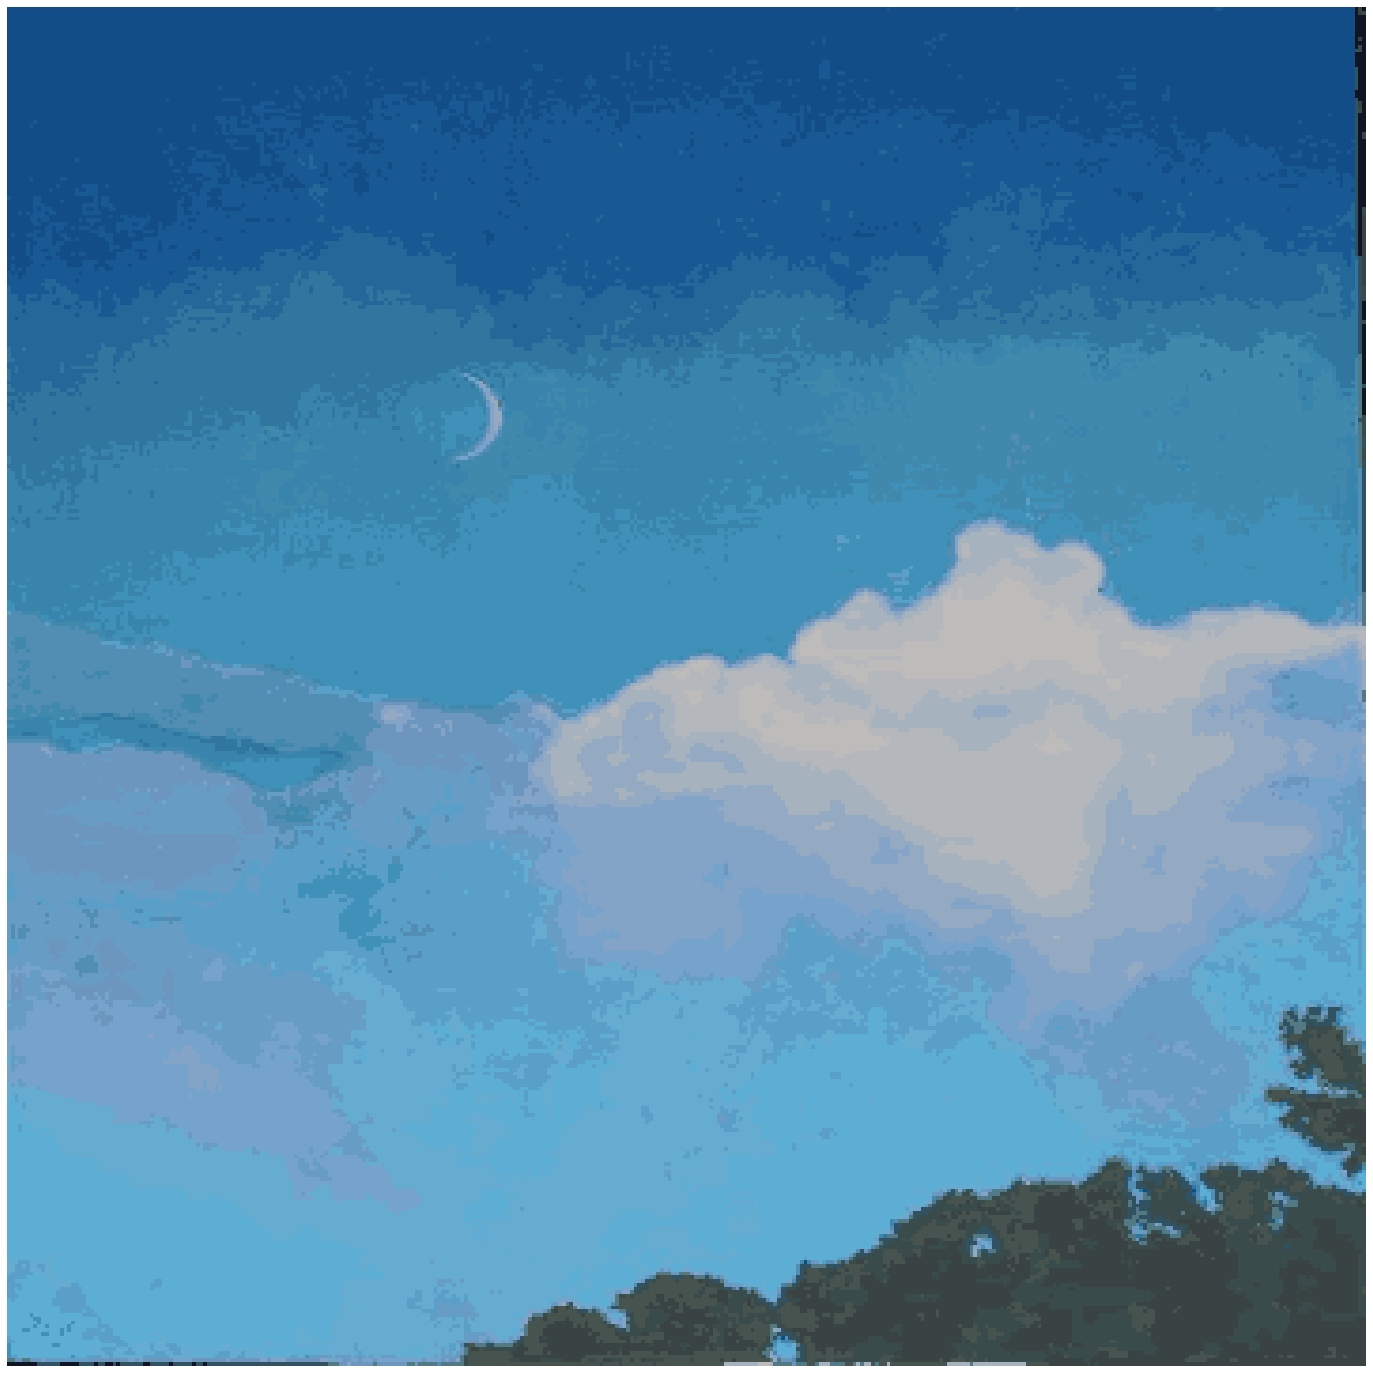

In [26]:
show_img_with_cluster_quality(target_name, data_labels, clu_data)

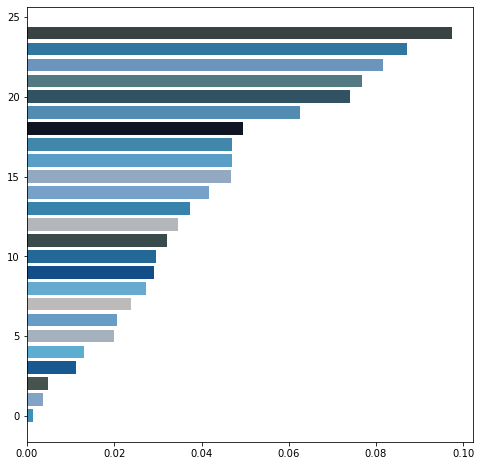

In [30]:
show_clu_by_ratio(clu_data)

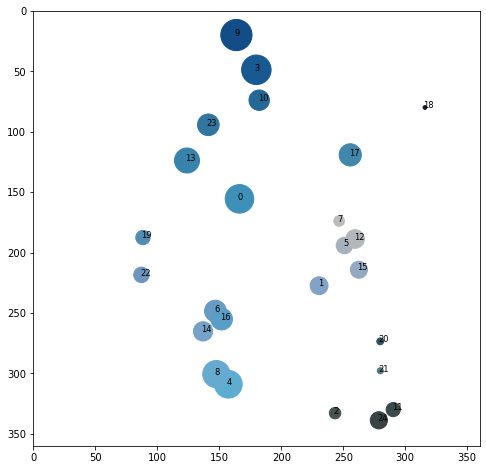

In [33]:
show_clu_by_pos(clu_data)

In [35]:
extract_color_v1("images/", "HSV25_saves/", img_size = (360, 360), clu = 25) #WARNING : Too heavy works (Takes long Time)

100%|███████████████████████████████████████████████████████████████████████████| 5411/5411 [00:00<00:00, 26595.66it/s]
